# Universal differential equation for SIR ODE model

The script provided below is closely based on and inspired by the tutorial available at the following link: https://docs.sciml.ai/Overview/stable/showcase/missing_physics/

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(1111);

### Define the SIR dynamics and solve the ODE

In [2]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ODE = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0);

In [3]:
prob = ODEProblem(sir!, u0, tspan, p_ODE)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

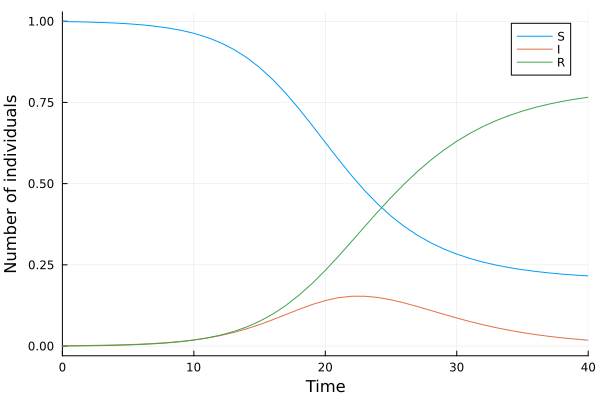

In [4]:
plot(sol, xlabel = "Time", ylabel = "Number of individuals", labels = ["S" "I" "R"])

### Add multiplicative log-normal noise

In [5]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.01)
noise = rand(rng, dist, size(X))
X_noisy = noise .* X;

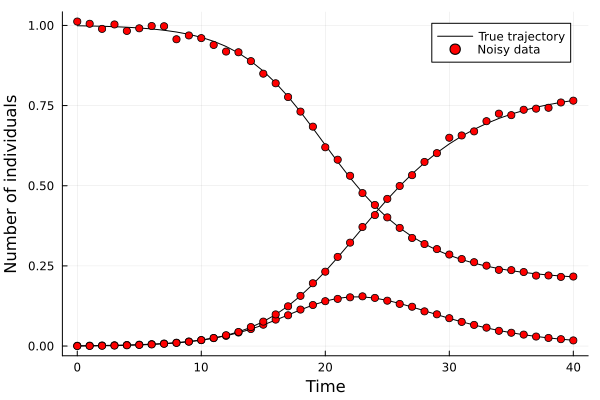

In [6]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals",
     color = :black, label=["True trajectory" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

### Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u)+\text{NN}(u)$.

In [7]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))   

# Multi-layer feed-forward neural network
model = Chain(Dense(3, 5, rbf), Dense(5, 5, rbf), Dense(5, 2))

# Get initial parameters and state variables of the model
p_init, st = Lux.setup(rng, model);

In [8]:
# Define the hybrid model
β, γ, N = p_ODE

function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = -γ*u[2] + nn[2] 
    du[3] = γ*u[2]
end

prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### Set up the training

In [9]:
function predict(p)   # p is the parameter of the NN and the ODE at the same time
    _prob = remake(prob_ude, p=p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = t,
                sensealg=QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [10]:
function loss(p)
    X̂ = predict(p)
    mean(abs2, X_noisy .- X̂)   # MSE loss
end;

In [11]:
losses = Float64[]

function callback(p, l)
    push!(losses, l)
    n_iter = length(losses)
    if n_iter % 50 == 0   
        println("Loss after $(n_iter) iterations: $(losses[end])")
    end
    return false
end;

### Train the UDE

In [12]:
adtype = AutoZygote()   # automatic differentiation
optf = OptimizationFunction((p, _) -> loss(p), adtype)
optprob = OptimizationProblem(optf, ComponentVector{Float64}(p_init));

In [13]:
res1 = solve(optprob, ADAM(), callback = callback, maxiters = 5000);

Loss after 50 iterations: 111.15470275904595
Loss after 100 iterations: 7.7767227318415975
Loss after 150 iterations: 2.22733344263582
Loss after 200 iterations: 0.6800184344587122
Loss after 250 iterations: 0.17210514624140866
Loss after 300 iterations: 0.04001821033903105
Loss after 350 iterations: 0.03162401026632271
Loss after 400 iterations: 0.03081132057159312
Loss after 450 iterations: 0.029918059106961586
Loss after 500 iterations: 0.02892904455649426
Loss after 550 iterations: 0.027835966032202758
Loss after 600 iterations: 0.02662957810962801
Loss after 650 iterations: 0.025300670597381145
Loss after 700 iterations: 0.023841849628369455
Loss after 750 iterations: 0.022250548340223945
Loss after 800 iterations: 0.020533601997577852
Loss after 850 iterations: 0.018713178998546603
Loss after 900 iterations: 0.0168324669558736
Loss after 950 iterations: 0.014957330895865428
Loss after 1000 iterations: 0.013168887433979419
Loss after 1050 iterations: 0.011545078118274042
Loss afte

In [14]:
optprob2 = OptimizationProblem(optf, res1.u)
res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = 1000)
p_trained = res2.u;

Loss after 5050 iterations: 0.0001230596841181007
Loss after 5100 iterations: 3.359203350416287e-5
Loss after 5150 iterations: 2.5242229925884047e-5
Loss after 5200 iterations: 2.3928587494980533e-5
Loss after 5250 iterations: 2.357568425897118e-5
Loss after 5300 iterations: 2.354072513047397e-5
Loss after 5350 iterations: 2.3487036289178765e-5
Loss after 5400 iterations: 2.3467702850271186e-5
Loss after 5450 iterations: 2.271003916844549e-5
Loss after 5500 iterations: 2.2310180824422152e-5
Loss after 5550 iterations: 2.1985608685951428e-5
Loss after 5600 iterations: 2.172651691474095e-5
Loss after 5650 iterations: 2.148716129001047e-5
Loss after 5700 iterations: 2.145395645446165e-5
Loss after 5750 iterations: 2.1431111751716095e-5
Loss after 5800 iterations: 2.1428760588648086e-5
Loss after 5850 iterations: 2.1426860296401426e-5
Loss after 5900 iterations: 2.1424356631982396e-5
Loss after 5950 iterations: 2.141425114662578e-5
Loss after 6000 iterations: 2.140608516290768e-5


### Visualize the results

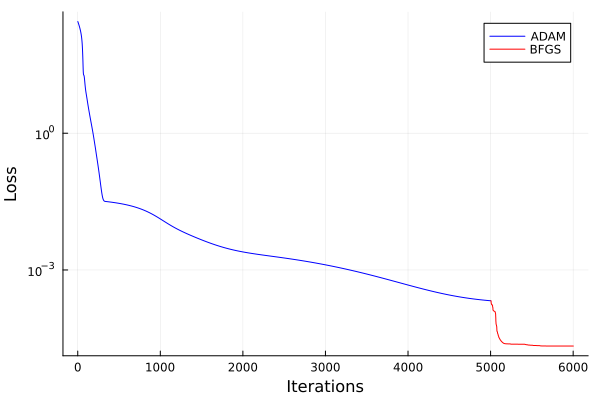

In [15]:
plot(1:5000, losses[1:5000], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM", color=:blue)
plot!(5001:length(losses), losses[5001:end], yaxis=:log10, label="BFGS", color = :red)

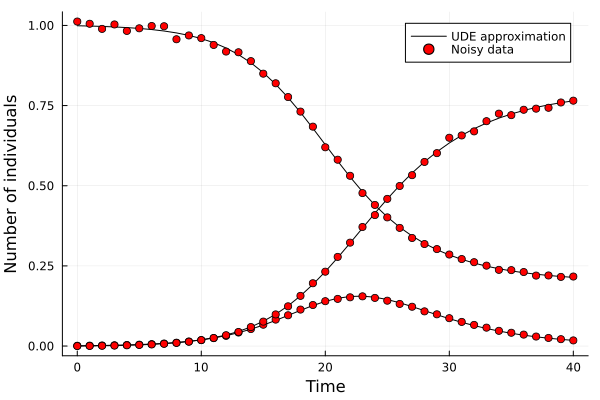

In [16]:
X̂ = predict(p_trained)
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

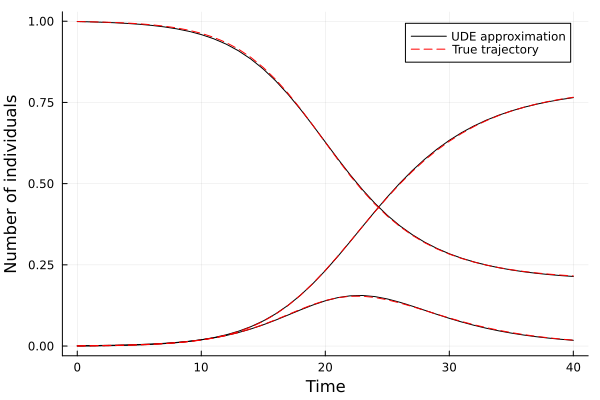

In [17]:
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
plot!(t, X', color = :red, linestyle=:dash, label=["True trajectory" nothing nothing])

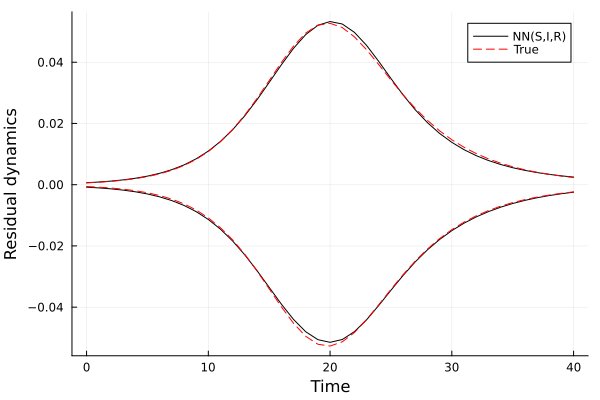

In [18]:
# True residual dynamics (i.e. interactions of predictors) along the true trajectory
dynamics_true = [-β/N * (X[1, :] .* X[2, :])'; β/N * (X[1, :] .* X[2, :])']
# Neural network guess along the approximated trajectory
dynamics_nn = Lux.apply(model, X̂, p_trained, st)[1]

plot(t, dynamics_nn', xlabel = "Time", ylabel = "Residual dynamics", color = :black,
     label = ["NN(S,I,R)" nothing ])
plot!(t, dynamics_true', color = :red, linestyle=:dash, label = ["True" nothing])